In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/518.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1307.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1048.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1399.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1661.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1577.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/665.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1212.bmp
/kaggle/input/leukemia-classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy import savetxt

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
# For reproducibility
np.random.seed(42)
from numpy.random import seed
seed(42)

In [3]:
# Creating train_ds and val_ds for model
# This will go through the folder and find photos and classify them based on folder location
# ie. if in all folder will label all (1)
train_ds = image_dataset_from_directory(
    '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 3527 files belonging to 2 classes.
Using 2822 files for training.
Found 3527 files belonging to 2 classes.
Using 705 files for validation.




1. `image_dataset_from_directory` is a function provided by the TensorFlow `tf.keras.preprocessing` module that creates a dataset of images from a directory. This function reads images from the directory and returns a `tf.data.Dataset` object.
2. The first argument to `image_dataset_from_directory` is the directory path from which the images should be read.
3. `image_size` argument specifies the size of the images to be read.
4. `batch_size` argument specifies the number of images to be read at once.
5. `seed` argument specifies the random seed to be used for reproducibility.
6. `validation_split` argument specifies the fraction of the dataset to be used for validation.
7. `subset` argument specifies whether the dataset being created is for training or validation.
8. `label_mode` argument specifies the type of label to be used. In this case, it's binary classification.


1. `val_ds` creates a separate dataset for validation data.
2. All the arguments are the same as in `train_ds`, except for the `subset` argument which is set to `'validation'` to indicate that this is a validation dataset.


In [4]:
# Calculating null model
print(f'ALL is {round(2397/3527,2)}%')
print(f'HEM is {round(1130/3527, 2)}%')

ALL is 0.68%
HEM is 0.32%


Text(0.5, 0.98, 'ALL (0) Vs HEM (1) Cells')

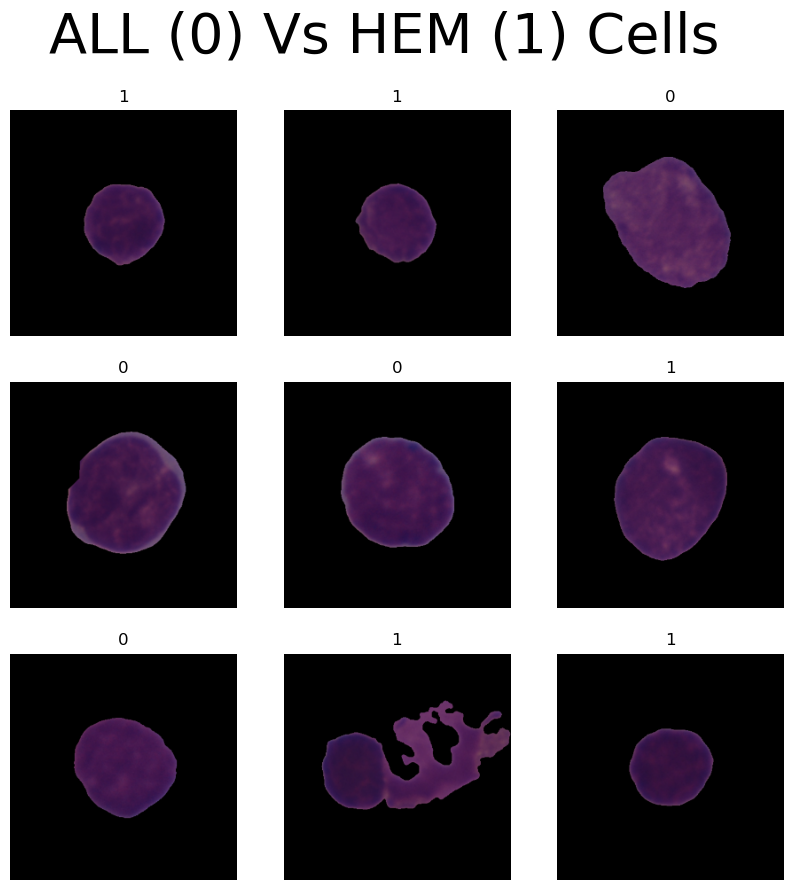

In [5]:
# Performing EDA on classes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.suptitle('ALL (0) Vs HEM (1) Cells', fontsize = 40) 
#plt.savefig('/content/drive/MyDrive/ga_project_4/all_vs_hem_cells')

* This code block is performing exploratory data analysis (EDA) on the classes of a dataset.

* **plt.figure(figsize=(10, 10))**: creates a new figure object with a size of 10x10 inches.
* **for images, labels in train_ds.take(1)**:: loops through the first batch of images and labels in the training dataset.
* **for i in range(9)**:: loops through the first 9 images in the batch.
* **ax = plt.subplot(3, 3, i + 1)**: creates a new subplot with a 3x3 grid of plots and assigns it to a variable ax.
* **plt.imshow(images[i].numpy().astype("uint8"))**: displays the i-th image in the subplot as a grayscale image.
* **plt.title(int(labels[i]))**: sets the title of the subplot to the corresponding label of the i-th image (0 or 1).
* **plt.axis("off")**: removes the axis from the subplot.
* **plt.suptitle('ALL (0) Vs HEM (1) Cells', fontsize = 40)**: sets the super title of the figure to "ALL (0) Vs HEM (1) Cells" with a font size of 40.

In [6]:
# Base Model
model_b = Sequential()

model_b.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_b.add(layers.Rescaling(1./255))


# First convolution
model_b.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_b.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_b.add(Conv2D(64, (3,3), activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_b.add(Flatten())

# Fully Connected
model_b.add(Dense(64, activation='relu'))
model_b.add(Dense(1, activation='sigmoid'))

#Compile
model_b.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

The code creates a base model for image classification using the Sequential model in Keras. 

* model_b = Sequential() 
- This creates an instance of the Sequential model, which allows us to stack layers on top of each other to create a neural network.


* model_b.add(layers.Input(shape = (256,256,3)))
- This adds an input layer to the model with the shape (256,256,3), which means that it will take in images of size 256x256 with 3 color channels (RGB).


* model_b.add(layers.Rescaling(1./255))
- This adds a Rescaling layer to the model, which scales the pixel values of the input images between 0 and 1. This is a common preprocessing step for image data.

* model_b.add(Conv2D(64, (3,3), activation = 'relu'))
- This adds a convolutional layer to the model with 64 filters, each of size 3x3. The activation function used is ReLU, which is a common choice for convolutional layers.

* model_b.add(MaxPooling2D(pool_size = (2,2)))
- This adds a max pooling layer to the model with a pool size of 2x2. This layer downsamples the output of the previous convolutional layer by taking the maximum value in each 2x2 region.


* model_b.add(Conv2D(64, (3,3), activation='relu'))
* model_b.add(MaxPooling2D(pool_size=(2,2)))
- These two lines add another convolutional layer and max pooling layer with the same configurations as the previous ones.


* model_b.add(Flatten())
- This flattens the output of the previous layer into a 1D vector, which can then be fed into a fully connected layer.


* model_b.add(Dense(64, activation='relu'))
* model_b.add(Dense(1, activation='sigmoid'))
- These two lines add two fully connected layers with 64 and 1 neurons, respectively. The first layer uses ReLU activation, while the second uses sigmoid activation, which is common for binary classification problems.


* model_b.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
- This compiles the model with the Adam optimizer, binary crossentropy loss function (since we have a binary classification problem), and accuracy as the evaluation metric.

In [7]:
h_b = model_b.fit(train_ds, validation_data= val_ds, epochs = 5)

Epoch 1/5
89/89 [==============================] - 36s 233ms/step - loss: 0.4689 - accuracy: 0.8012 - val_loss: 0.4379 - val_accuracy: 0.8142
Epoch 2/5
89/89 [==============================] - 9s 96ms/step - loss: 0.4159 - accuracy: 0.8253 - val_loss: 0.4550 - val_accuracy: 0.8000
Epoch 3/5
89/89 [==============================] - 9s 101ms/step - loss: 0.3823 - accuracy: 0.8373 - val_loss: 0.4592 - val_accuracy: 0.8184
Epoch 4/5
89/89 [==============================] - 9s 101ms/step - loss: 0.3442 - accuracy: 0.8494 - val_loss: 0.4644 - val_accuracy: 0.8000
Epoch 5/5
89/89 [==============================] - 9s 100ms/step - loss: 0.2964 - accuracy: 0.8770 - val_loss: 0.5285 - val_accuracy: 0.7887


This code trains the model model_b on the training data train_ds and evaluates it on the validation data val_ds for 5 epochs. The fit() function returns a history object h_b which contains the training loss, training accuracy, validation loss, and validation accuracy for each epoch. These metrics can be used to monitor the performance of the model during training and to identify if the model is overfitting or underfitting.

In [8]:
 # Scoring model
print(h_b.history['loss'][-1], h_b.history['val_loss'][-1])
print(h_b.history['accuracy'][-1], h_b.history['val_accuracy'][-1])

0.29640519618988037 0.528498113155365
0.8770375847816467 0.7886524796485901


* h_b.history contains the training and validation metrics (loss and accuracy) of the trained model model_b.
* h_b.history['loss'] represents the training loss of the model over each epoch of training.
* h_b.history['val_loss'] represents the validation loss of the model over each epoch of training.
* h_b.history['accuracy'] represents the training accuracy of the model over each epoch of training.
* h_b.history['val_accuracy'] represents the validation accuracy of the model over each epoch of training.
* h_b.history['loss'][-1] and h_b.history['val_loss'][-1] give us the loss of the last epoch of training and validation, respectively.
* h_b.history['accuracy'][-1] and h_b.history['val_accuracy'][-1] give us the accuracy of the last epoch of training and validation, respectively.
* Therefore, the code prints the loss and accuracy of the last epoch of both training and validation.

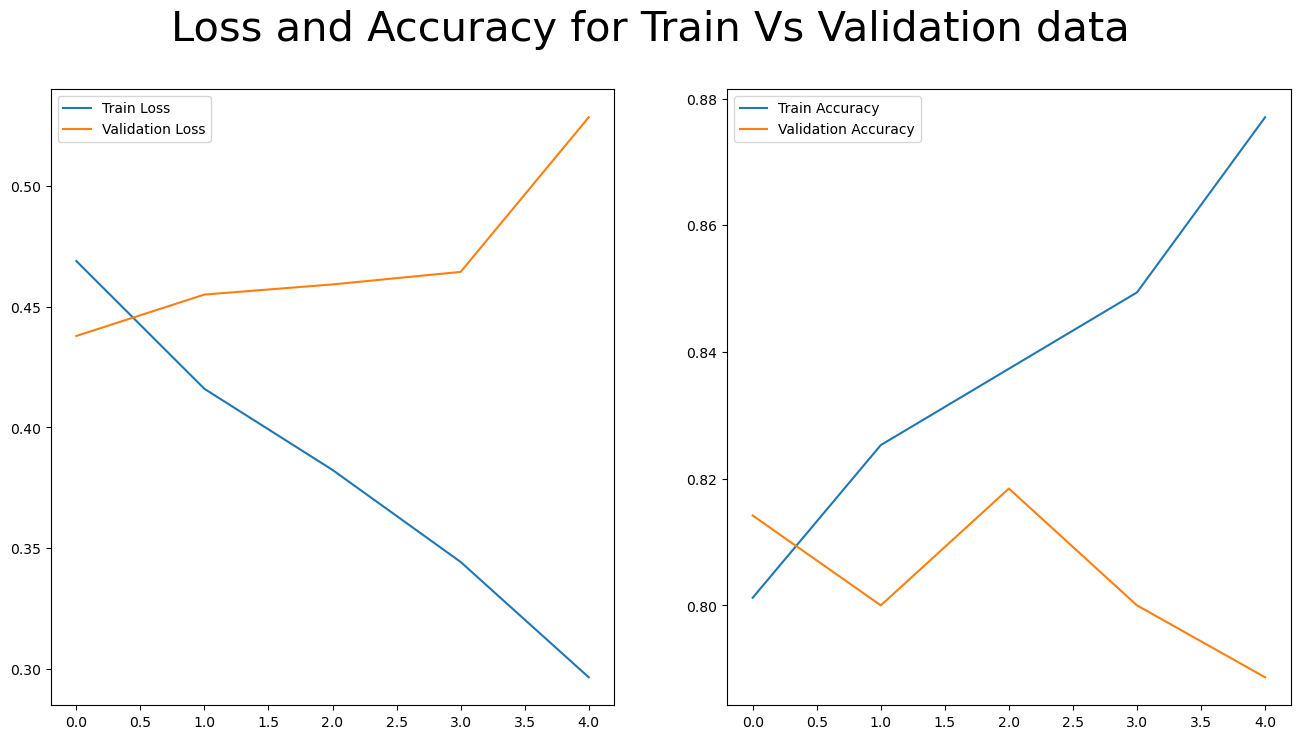

In [9]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(h_b.history['loss'], label = 'Train Loss'),
ax1.plot(h_b.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_b.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_b.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();


* fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),) creates a figure with two subplots, one for the loss and the other for accuracy. The figsize parameter sets the size of the figure.
* fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30) sets the main title of the figure.
* ax1.plot(h_b.history['loss'], label = 'Train Loss'), plots the training loss as a line graph and labels it as 'Train Loss'.
* ax1.plot(h_b.history['val_loss'], label = 'Validation Loss'), plots the validation loss as a line graph and labels it as 'Validation Loss'.
* ax1.legend() displays a legend for the two lines in the first subplot.
* ax2.plot(h_b.history['accuracy'], label = 'Train Accuracy'), plots the training accuracy as a line graph and labels it as 'Train Accuracy'.
* ax2.plot(h_b.history['val_accuracy'], label = 'Validation Accuracy') plots the validation accuracy as a line graph and labels it as 'Validation Accuracy'.
* ax2.legend(); displays a legend for the two lines in the second subplot.

In [10]:
# Instantiating data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

**Data augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing data. This is typically done by applying random transformations to the original data, such as rotating, flipping, zooming, shifting, or changing the brightness and contrast. Data augmentation is commonly used in deep learning to prevent overfitting and improve the generalization of a model by exposing it to a wider range of possible inputs.**

* data_augmentation = keras.Sequential() : creates a sequential model object to stack layers of data augmentation.
* layers.RandomFlip("horizontal"): adds a layer of random horizontal flipping to the sequential model object. This flips the input tensor horizontally, with a 50% probability.
* layers.RandomRotation(0.1): adds a layer of random rotation to the sequential model object. This rotates the input tensor by a random angle between -0.1 and 0.1 radians.

Text(0.5, 0.98, 'Leukocyte With Augmentation Applied')

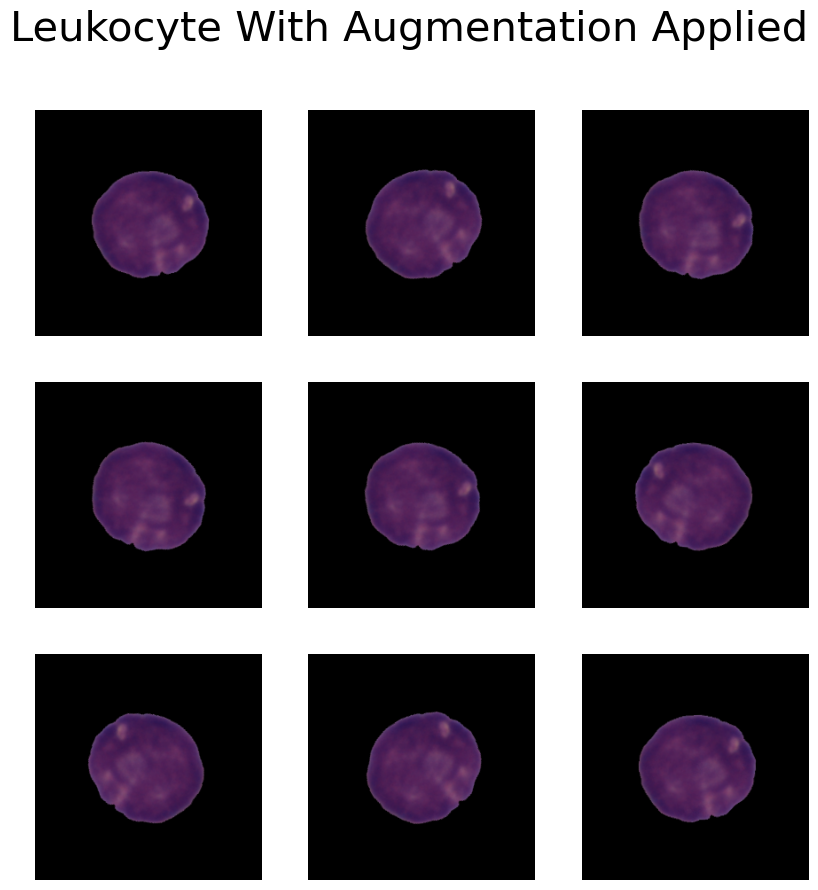

In [11]:
# Plotting one image with data augmentation applied
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle('Leukocyte With Augmentation Applied', fontsize = 30) 

In [12]:
# Apply `data_augmentation` to the training images. Code adapted from https://keras.io/examples/vision/image_classification_from_scratch/
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization. 
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
# Base Model
model_1 = Sequential()

model_1.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_1.add(layers.Rescaling(1./255))


# First convolution
model_1.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_1.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_1.add(Conv2D(64, (3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_1.add(Flatten())

# Fully Connected
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

#Compile
model_1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [14]:
# Fitting augmented model with 5 epochs
h_1 = model_1.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 25s 250ms/step - loss: 0.4783 - accuracy: 0.8118 - val_loss: 0.4573 - val_accuracy: 0.8113
Epoch 2/10
89/89 [==============================] - 23s 253ms/step - loss: 0.4506 - accuracy: 0.8140 - val_loss: 0.4292 - val_accuracy: 0.8340
Epoch 3/10
89/89 [==============================] - 23s 256ms/step - loss: 0.4505 - accuracy: 0.8118 - val_loss: 0.4332 - val_accuracy: 0.8170
Epoch 4/10
89/89 [==============================] - 24s 265ms/step - loss: 0.4391 - accuracy: 0.8150 - val_loss: 0.4705 - val_accuracy: 0.8043
Epoch 5/10
89/89 [==============================] - 23s 253ms/step - loss: 0.4245 - accuracy: 0.8292 - val_loss: 0.4090 - val_accuracy: 0.8270
Epoch 6/10
89/89 [==============================] - 24s 260ms/step - loss: 0.4148 - accuracy: 0.8342 - val_loss: 0.4509 - val_accuracy: 0.8255
Epoch 7/10
89/89 [==============================] - 23s 246ms/step - loss: 0.3987 - accuracy: 0.8327 - val_loss: 0.4277 - val_accuracy: 0.8270

In [15]:

# Scoring model
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.31840240955352783 0.35600706934928894
0.8660524487495422 0.8482269644737244


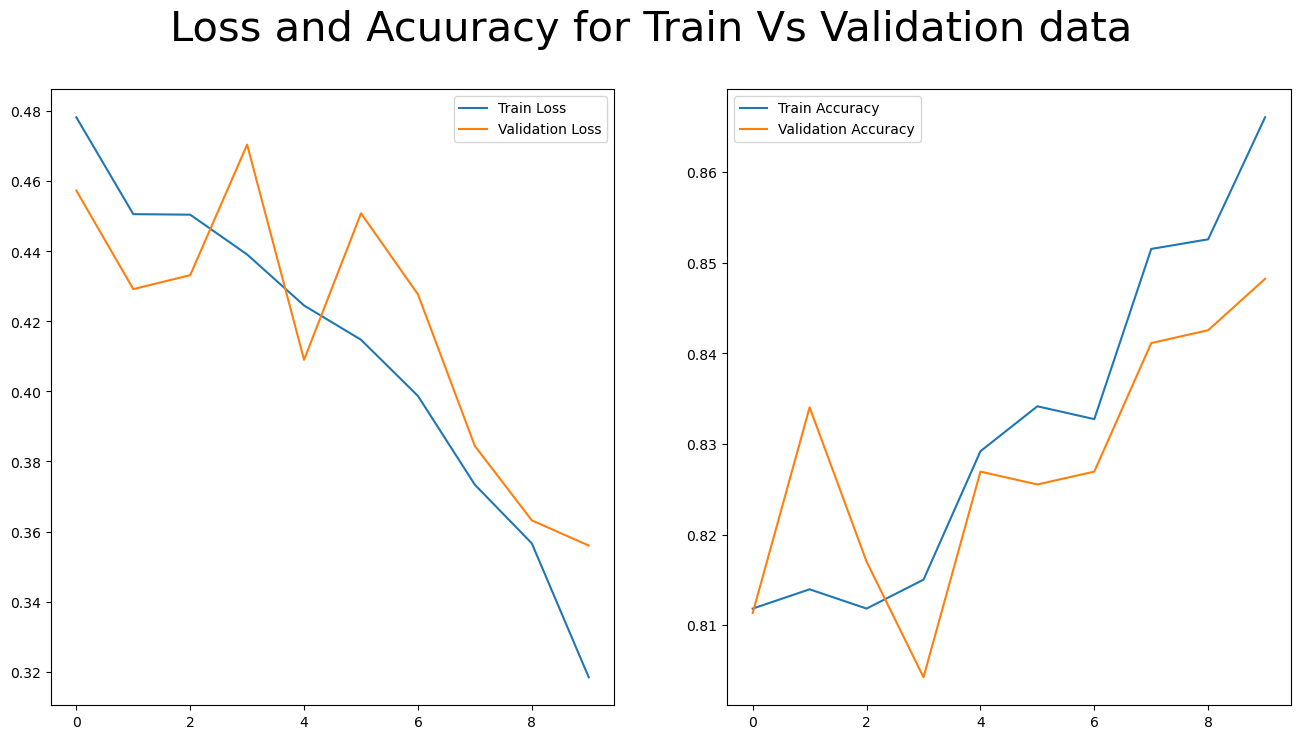

In [16]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(h_1.history['loss'], label = 'Train Loss'),
ax1.plot(h_1.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_1.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_1.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

In [17]:
test_img_all = img_to_array(load_img('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all/UID_51_180_2_all.bmp'))
test_img_all.shape

(450, 450, 3)

In [18]:
# Need to reshape image
test_img_all = smart_resize(test_img_all, (256,256))
test_img_all.shape

(256, 256, 3)

In [19]:
# Adding extra dimension for model to work
test_image_all = np.expand_dims(test_img_all, axis = 0)
test_image_all.shape

(1, 256, 256, 3)

In [20]:
# Predicting if image is ALL
model_1.predict(test_image_all)

1/1 [==============================] - 0s 109ms/step


array([[0.05433572]], dtype=float32)

In [21]:
# Turn HEM image into array to feed into model to predict
test_img_hem = img_to_array(load_img('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem/UID_H22_36_8_hem.bmp'))
test_img_hem.shape

(450, 450, 3)

In [22]:
# Need to reshape image
test_img_hem = smart_resize(test_img_hem, (256,256))
test_img_hem.shape


(256, 256, 3)

In [23]:
# Adding extra dimension for model to work
test_image_hem = np.expand_dims(test_img_hem, axis = 0)
test_image_hem.shape

(1, 256, 256, 3)

In [24]:
# Predicting if image is ALL
model_1.predict(test_image_hem)

1/1 [==============================] - 0s 22ms/step


array([[0.9981059]], dtype=float32)